In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
# from preprocess import preprocess, tokenize

import warnings
warnings.filterwarnings('ignore')

In [4]:
# with open('/kaggle/input/python-dataset-source-code-summarization/preprocess.py', 'r') as file:
#     file_content = file.read()

# # Execute the code in the file
# exec(file_content)

import sys
sys.path.append('/kaggle/input/python-dataset-source-code-summarization/')

from preprocess import preprocess, tokenize

**Loading Dataset:**

In [4]:
# !unzip "drive/My Drive/Colab Notebooks/SourceCodeSummarization/python_dataset.zip" -d "Datasets"

In [5]:
df = pd.read_csv("/kaggle/input/python-dataset-source-code-summarization/python_dataset/python_dataset.csv")
df = df[['code', 'docstring']]
print(df.shape)
pd.options.display.max_colwidth = 100
df.head()

(593891, 2)


,code,docstring
0,"sorted(l, key=lambda x: (-int(x[1]), x[0]))",Sort a nested list by two elements
1,[int(x) for x in str(num)],converting integer to list in python
2,c.decode('unicode_escape'),Converting byte string in unicode string
3,"parser.add_argument('-t', dest='table', help='', nargs='+')",List of arguments with argparse
4,"datetime.datetime.strptime(s, '%Y-%m-%dT%H:%M:%SZ')",How to convert a Date string to a DateTime object?


### Preprocessing

In [6]:
# max len decided based on max & quartiles
max_code_len = 100
max_summary_len = 25

In [7]:
df = preprocess(df, max_code_len, max_summary_len)
print(df.shape)
df.head()

(592846, 2)


,code,docstring
0,sorted key lambda -int,sostok sort nested list by two elements eostok
1,int for in str num,sostok converting integer to list in python eostok
2,c decode unicode escape,sostok converting byte string in unicode string eostok
3,parser add argument -t dest table help nargs,sostok list of arguments with argparse eostok
4,strptime y d h sz,sostok how to convert date string to date time object eostok


### Train-Test split and Tokenization

In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(
    np.array(df['code']),
    np.array(df['docstring']),
    test_size=0.15,
    random_state=0,
    shuffle=True
)

print("Train: ", X_train.shape)
print("Val: ", X_val.shape)

Train:  (503919,)
Val:  (88927,)


In [9]:
import os
if not os.path.exists('pickle'):
    os.makedirs('pickle')

**Tokenizing code:**

In [10]:
x_tokenizer_path = 'pickle/x_tokenizer.pickle'
x_train = tokenize(list(X_train), max_pad_len=max_code_len, tokenizer_path=x_tokenizer_path, thresh=3, fit_on_texts=True)
with open(x_tokenizer_path, 'rb') as handle:
    x_tokenizer = pickle.load(handle)
    
x_vocab_size = x_tokenizer.num_words + 1
print("X Vocab Size: ", x_vocab_size)

X Vocab Size:  26048


In [11]:
x_train

array([[   8,  444,  137, ...,    0,    0,    0],
       [ 144, 4943,  122, ...,    0,    0,    0],
       [   3, 4881,   11, ...,    0,    0,    0],
       ...,
       [ 774,  667, 9559, ...,    0,    0,    0],
       [ 294, 3082,   12, ...,    0,    0,    0],
       [ 588,  398,   74, ...,    0,    0,    0]], dtype=int32)

In [12]:
x_val = tokenize(list(X_val), max_pad_len=max_code_len, tokenizer_path=x_tokenizer_path, thresh=3, fit_on_texts=False)

In [13]:
x_val

array([[  0,   0,   0, ...,   0,   0,   0],
       [666,  19,  40, ...,   0,   0,   0],
       [ 15, 900,   7, ...,   0,   0,   0],
       ...,
       [164,  22, 286, ...,   0,   0,   0],
       [ 14,  34,  55, ...,   0,   0,   0],
       [  4, 263, 871, ...,   0,   0,   0]], dtype=int32)

**Tokenizing summary:**

In [14]:
y_tokenizer_path = 'pickle/y_tokenizer.pickle'
y_train = tokenize(list(Y_train), max_pad_len=max_summary_len, tokenizer_path=y_tokenizer_path, thresh=2, fit_on_texts=True)
with open(y_tokenizer_path, 'rb') as handle:
    y_tokenizer = pickle.load(handle)
    
y_vocab_size = y_tokenizer.num_words + 1
print("Y Vocab Size: ", y_vocab_size)

Y Vocab Size:  10598


In [15]:
y_val = tokenize(list(Y_val), max_pad_len=max_summary_len, tokenizer_path=y_tokenizer_path, thresh=2, fit_on_texts=False)
y_val

array([[   1,   25,   11, ...,    0,    0,    0],
       [   1,    6,    5, ...,    0,    0,    0],
       [   1,  197,  152, ...,    0,    0,    0],
       ...,
       [   1,    6,    5, ...,    0,    0,    0],
       [   1,   22,  288, ...,    0,    0,    0],
       [   1,    3, 1187, ...,    0,    0,    0]], dtype=int32)

**TODO: Glove**
Using standard word vectors like GloVe instead of basic tokenisation

# Encoder Decoder Architecture and Training

In [16]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

The below code implements a sequence-to-sequence (seq2seq) model with an encoder-decoder architecture using LSTM layers.
<details>
    <summary>Click to see details</summary>

SUMMARY:

1. Encoder:

    - **The encoder is responsible for encoding the input code sequences into a fixed-length vector.**
    - It is defined using the Input layer, which represents the input sequences of source code snippets. The shape of the inputs is (max_code_len, ), indicating the maximum length of the code sequence.
    - An embedding layer (Embedding) is used to convert the input code sequences into dense vectors of embedding_dim dimensions. This layer learns the representations of the input words during training.
    - Three stacked LSTM layers are used to process the embedded input sequences in a step-by-step manner, generating intermediate outputs while updating their internal states.
    - Each LSTM layer is followed by a dropout layer to prevent overfitting. The last LSTM layer returns both the output sequence (encoder_outputs) and the final internal states (state_h, state_c), that capture the summarized information about the input sequence.


2. Decoder:
    - **The decoder takes the encoded representation from encoder and generates the target summary.**
    - The decoder inputs are defined using the Input layer, representing the input sequences of target summaries. The shape of the inputs is (None, ), indicating variable-length sequences.
    - Another embedding layer (Embedding) is used to convert the input summary sequences into dense vectors of the same embedding_dim dimensions.
    - The decoder LSTM layer (LSTM) takes the embedded decoder inputs as input and also receives the states from the encoder LSTM as initial states. This allows the decoder to leverage the encoded information from the input code sequences.
    - The intermediate decoder outputs are then passed through a time-distributed dense layer, which produces the predicted probability distribution over the vocabulary for each time step in the output sequences.


3. Model Construction:
    - The model is defined taking the encoder_inputs, decoder_inputs as inputs and produces the decoder_outputs as model's output.


This model architecture allows for training a sequence-to-sequence model to translate source code snippets (encoder inputs) into corresponding summaries (decoder outputs).
</details>

*The encoder LSTM layers encode the input code sequences, and the decoder LSTM layer generates the target summaries based on the encoded information. The embedding layers provide dense representations of the words in both the code and summary sequences.*

NOTE: **state vectors:**
- final hidden state (state_h) and final cell state (state_c)


In [17]:
latent_dim = 300
embedding_dim = 200

### Encoder ###
encoder_inputs = Input(shape=(max_code_len, ))

# Embedding layer
enc_emb = Embedding(x_vocab_size, embedding_dim, trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)


### Decoder ###

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_vocab_size, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

## Dense layer
decoder_dense = TimeDistributed(Dense(y_vocab_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

## Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 200)     5209600     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 100, 300),   601200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

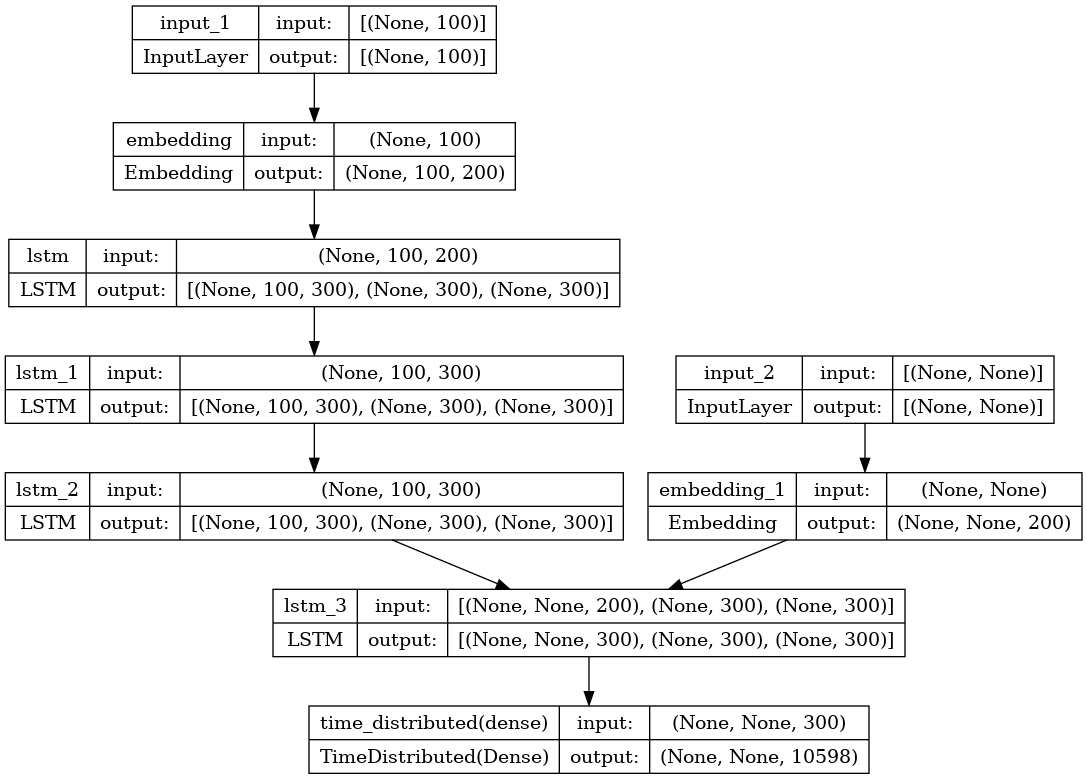

In [18]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
# plot_model(model, show_shapes=True)

In [19]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [20]:
# y_train[:, :-1]

In [21]:
# # GPU ??
# import tensorflow as tf
# print("GPU Available:", tf.test.is_gpu_available())
# print("Physical Devices:", tf.config.experimental.list_physical_devices('GPU'))

GPU Available: True
Physical Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


### Mode fitting...

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

checkpoint_path = 'model_checkpoints/model.{epoch:02d}-{val_loss:.2f}.h5'
tensorboard_log_dir = 'logs/'

# ModelCheckpoint callback to save the best model during training
checkpoint_callback = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)

# TensorBoard callback for visualizing training metrics
# tensorboard_callback = TensorBoard(log_dir=tensorboard_log_dir, histogram_freq=1)

history = model.fit(
    [x_train, y_train[:, :-1]],
    y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:, 1:],
    epochs=20,
    batch_size=128,
    validation_data=([x_val, y_val[:, :-1]],
                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:]),
    callbacks=[early_stopping, checkpoint_callback]
)

*The model has been trained on GPUs using the `train.py` script containing a cleaner code of this notebook.*

**TODO:** Experiment with various configurations and hyperparameters like batch_size, epoch, etc.

In [ ]:
# # y_train[:, :-1] => removes last word from each sequence
# # coz in seq2seq model, we predict next word at each timestep
# history = model.fit(
#     [x_train, y_train[:, :-1]],
#     y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:, 1:],
#     epochs=50,
#     callbacks=[es],
#     batch_size=128,
#     validation_data=([x_val, y_val[:, :-1]],
#                      y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:]),
#     )

`.h5` model format can have the full model architecture with all the weights.

In [ ]:
model.save('trained_model.h5')

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.savefig('loss_plot.png')
plt.show()

### Prediction Model
Decoding sequence for prediction

In [23]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

Defining models `encoder_model` and `decoder_model` for prediction:

<details>
    <summary>Click to see details</summary>

- `encoder_model` takes the encoder inputs (encoder_inputs) and the encoder states (encoder_states) as inputs and returns the encoder states (encoder_states) as outputs.
- This model is used to encode the input code sequences and retrieve the encoded information.

- `decoder_model` takes the decoder inputs (decoder_inputs) and the initial decoder states (decoder_states_inputs) as inputs and returns the decoder outputs (decoder_outputs) and decoder states (decoder_states) as outputs.
- The decoder states (decoder_states) are used to generate the next word in the summary sequence.

</details>

In [24]:
## Encoder ##
# used to encode the input code sequence
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

## Decoder setup ##

# Tensors to hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_code_len, latent_dim))  # encoded code sequence

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)     # DOUBT: Why again? We already have dec_emb ?

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
# decoder_model.summary()
# plot_model(decoder_model, to_file='decoder_model.png', show_shapes=True)

predict_summary:
- We are using the encoder model to obtain the encoded representation of the input sequence,
- and then feed that representation and the previous time step's states into the decoder model to generate the next word in the sequence.

In [25]:
# for generating the predicted decoded sequence
def predict_summary(input_seq):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq, verbose=0)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c], verbose=0)

        # Sample a token with the highest probability
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        # TODO: Pick 2nd max prob, if sampled_token_index=0
        if(sampled_token_index == 0):
            sampled_token_index = np.argsort(output_tokens[0, -1, :])[-2]

        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == 'eostok' or len(decoded_sentence.split()) \
            >= max_summary_len - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)      # Check

    return decoded_sentence

In [26]:
# Utility functions to generate strings sequences from integer (token) sequences
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['sostok'] and i != target_word_index['eostok']:
            newString += reverse_target_word_index[i] + ' '

    return newString

def seq2code(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString += reverse_source_word_index[i] + ' '

    return newString

In [ ]:
# predict for some of the sequences
for i in range(5, 10):
    print ('Code:', seq2code(x_train[i]))
    print ('Original summary:', seq2summary(y_train[i]))
    print ('Predicted summary:', predict_summary(x_train[i].reshape(1, max_code_len)))
    print ('\n')


# Evaluation

In [27]:
# ! pip install sacrebleu
# import sacrebleu
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
# BLEU Score for x_val
bleu_score = 0
diff = 0

for i in range(len(x_val)):

    pred_summary = predict_summary(x_val[i].reshape(1, max_code_len))
    # print(pred_summary)
    # print(seq2summary(y_val[i]))

    # BLEU score
    # curr_bleu = sacrebleu.sentence_bleu(pred_summary, seq2summary(y_val[i]).split(), smooth_method='exp').score
    curr_bleu = sentence_bleu(pred_summary.split(), seq2summary(y_val[i]).split())
    print(curr_bleu)
    bleu_score += curr_bleu

    # Check if below threshold
#     if curr_bleu < 5:
#         diff += 1

# average_bleu_score = bleu_score / (len(x_val) - diff)
average_bleu_score = bleu_score / (len(x_val))
print("Average BLEU Score on val:", average_bleu_score)

In [ ]:
print(len(x_val), diff)

**Test Data:**

In [28]:
testpath = "/kaggle/input/python-dataset-source-code-summarization/python_test_dataset.csv"
test = pd.read_csv(testpath)
test = test[['code', 'docstring']]
print(test.shape)
test.head()

(99, 2)


,code,docstring
0,"sum(d * 10 ** i for i, d in enumerate(x[::-1]))",How to convert a list of multiple integers into a single integer?
1,"r = int(''.join(map(str, x)))",How to convert a list of multiple integers into a single integer?
2,"datetime.strptime('2010-11-13 10:33:54.227806', '%Y-%m-%d %H:%M:%S.%f')",how to convert a datetime string back to datetime object?
3,"[(i, sum(j) / len(j)) for i, j in list(d.items())]",Averaging the values in a dictionary based on the key
4,"zip([1, 2], [3, 4])",zip lists in python


In [29]:
# preprocess test
post_test = preprocess(test, max_code_len, max_summary_len)
print(post_test.shape)
post_test.head()

(99, 2)


,code,docstring
0,sum i for d in enumerate ::,sostok how to convert list of multiple integers into single integer eostok
1,r int join map str,sostok how to convert list of multiple integers into single integer eostok
2,datetime strptime m h s,sostok how to convert datetime string back to datetime object eostok
3,sum len for j in list items,sostok averaging the values in dictionary based on the key eostok
4,zip,sostok zip lists in python eostok


In [30]:
# tokenize test
test_code = tokenize(list(post_test['code'].values), max_pad_len=max_code_len, tokenizer_path=x_tokenizer_path, thresh=3, fit_on_texts=False)
test_summary = tokenize(list(post_test['docstring'].values), max_pad_len=max_summary_len, tokenizer_path=y_tokenizer_path, thresh=2, fit_on_texts=False)

In [ ]:
# BLEU Score for test
bleu_score = 0
diff = 0

for i in range(len(test_code)):

    pred_summary = predict_summary(test_code[i].reshape(1, max_code_len))
    # print(pred_summary)
    # print(seq2summary(y_val[i]))

    # BLEU score
#     curr_bleu = sacrebleu.sentence_bleu(pred_summary, seq2summary(test_summary[i]).split(), smooth_method='exp').score
#     curr_bleu = sacrebleu.sentence_bleu(pred_summary, (post_test['docstring'][i]).split(), smooth_method='exp').score
    curr_bleu = sentence_bleu(pred_summary.split(), post_test['docstring'][i].split())
    print(curr_bleu)
    bleu_score += curr_bleu

    # Check if below threshold
    if curr_bleu < 5:
        diff += 1

# average_test_bleu_score = bleu_score / (len(test_code) - diff)
average_test_bleu_score = bleu_score / (len(test_code))
print("Average BLEU Score on val:", average_test_bleu_score)